In [2]:
import os
import sys
code_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code'
code_dir_2 = '/home/ben/ben-rhodes-masters-project/proposal/code'
code_dir_3 = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code/neural_network'
code_dirs = [code_dir, code_dir_2, code_dir_3]
for code_dir in code_dirs:
    if code_dir not in sys.path:
        sys.path.append(code_dir)

In [15]:
import numpy as np

# my code
from distribution import MissingDataProductOfTruncNormsPosterior, MissingDataProductOfTruncNormNoise
from fully_observed_models import MixtureOfTwoGaussians
from latent_variable_model import MissingDataUnnormalisedTruncNorm
from nce_optimiser import NCEOptimiser
from utils import *
from vnce_optimiser import VemOptimiser, SgdEmStep, MonteCarloVnceLoss

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.optimize import newton_krylov
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=1)
rc('font', size=10)
rc('legend', fontsize=10)
rc('text', usetex=True)

In [31]:
noise_mean = np.array([1, 1])
noise_chol = np.array([np.log(1/5), np.log(1/5)])

model_mean = np.array([0, 0])
model_chol = np.diag(np.array([np.log(1/2), np.log(1/2)]))

In [32]:
noise = MissingDataProductOfTruncNormNoise(noise_mean, noise_chol)
model = MissingDataUnnormalisedTruncNorm(model_mean, model_chol)

In [51]:
noise_samples = noise.sample(100000)
model_samples = model.sample(100000)

total num accepted: 0
total num accepted: 37372
total num accepted: 74668


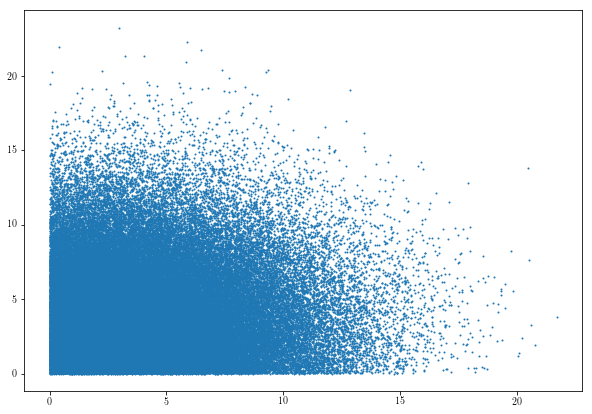

In [52]:
fig = plt.figure(figsize=(10, 7))
plt.scatter(noise_samples[:, 0], noise_samples[:, 1], s=1)

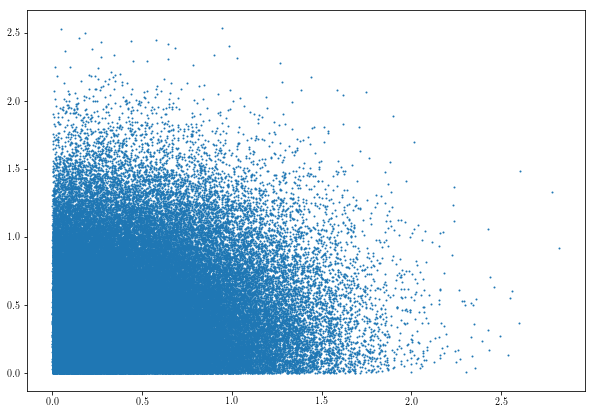

In [53]:
fig = plt.figure(figsize=(10, 7))
plt.scatter(model_samples[:, 0], model_samples[:, 1], s=1)